In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc
import time
import math

In [35]:
######################################### Constants taken from scipy.constants ###################################


# all in SI units
G = spc.G
c = spc.c
hbar = spc.hbar
k = spc.k
mp = spc.proton_mass
me = spc.electron_mass
sigma_sb = spc.sigma


########################################### Definfing constants required #########################################

Msun = 1.989e30
Rsun = 6.957e8
Lsun = 3.828e26
a = 4*sigma_sb/c
gamma = 5.0/3.0 #The adiabatic index has a value γ = 5/3 for simple atomic gases and fully ionized gases.
'''
check: is gamma value correct?
'''
#X, Y, Z = 0.734, 0.250, 0.016 #Values taken from Foundations of Astrophysics.
X, Y, Z = 0.70, 0.28, 0.02
'''
check X, Y, Z values
'''
mu = 1/(2*X + 0.75*Y + 0.5*Z)
class star(object):
    def __init__(self, r0, rho_c, T_c, step_size):

        '''
        Given r0, rho_c, T_c calculate M0 and L0
        M0 - Initial Mass
        L0 - Initial Luminosity
        tau0 - Initial optical depth
        '''
        self.accuracy = 1.5e-16

        self.M0 = (4.0/3.0)*np.pi*r0**3*rho_c
        self.L0 = self.M0*self.epsilon(rho_c, T_c) 
        self.tau0 = self.kappa(rho_c,T_c)*rho_c
        self.r0 = r0
        self.rho_c = rho_c
        self.T_c = T_c
        self.dr = step_size
        
        self.step_size_list = []
        
        #deltau
        self.deltau_values = []
        
        #lists for DE solutions
        self.rho_vals, self.T_vals, self.M_vals, self.L_vals, self.tau_vals, self.r_vals = [], [], [], [], [], []
        
        #lists for epsilon
        self.eps_vals, self.epp_vals, self.ecno_vals = [], [], []
        
        #lists for kappa
        self.kappa_vals, self.Kes_vals, self.Kff_vals, self.KH_vals = [], [], [], []
        
        #lists for pressure
        self.P_vals, self.P_nr_vals, self.P_ig_vals, self.P_pg_vals = [], [], [], []
        
        self.solve_DE()
        
        
################################################ Below are DEs required to solve ###################################

    def dpdr(self, r, rho, T, M, L):

        '''
        Hydrostatic equilibrium in rho
        '''

        return -(G*M*rho/r**2 + self.dPdT(rho, T)*self.dTdr(r, rho, T, M, L))/self.dPdp(rho, T)


    def dTdr(self, r, rho, T, M, L):

        '''
        Equation for energy transport. Minimum of energy transport
        due to convection and radiation
        '''

        dTdr_rad = 3*self.kappa(rho, T)*rho*L/(16*np.pi*a*c*T**3*r**2)
        dTdr_conv = (1 - 1.0/gamma)*T*G*M*rho/(self.P(rho, T)*r**2)

        return -min(dTdr_rad , dTdr_conv)


    def dMdr(self, r, rho):

        '''
        definition of enclosed mass
        '''

        return 4*np.pi*r**2*rho

    def dLdr(self, r, rho, T):

        '''
        Energy generation equation
        '''

        return 4*np.pi*r**2*rho*self.epsilon(rho, T)

    def dtaudr(self, rho, T):

        '''
        Optical Depth
        '''

        return self.kappa(rho, T)*rho


############################################# Functions to assist in solving DEs ###################################

    def epsilon(self, rho, T):
        '''
        Sum up energy generation due to proton-proton chain and CNO cycle
        '''

        rho5 = rho/1e5
        T6 = T/1e6
        Xcno = 0.03*X

        epp = 1.07e-7*rho5*X**2*T6**4
        ecno = 8.24e-26*rho5*X*Xcno*T6**(19.9)
        
        return epp + ecno


    def kappa(self, rho, T):

        '''
        Rosseland Mean Opacities.
        '''
        rho3 = rho/1e3

        Kes = 0.02*(1+X)
        Kff = 1e24*(Z+0.0001)*rho3**(0.7)*T**(-3.5)
        KH = 2.5e-32*(Z/0.02)*rho3**(0.5)*T**9

        '''
        Check: below I return eq 14, but the comments below the equation 14 in the
        project description say "near and below the net opacity is the minimum of that due to free-free/scattering
        and that due to H". I am not entirely sure if I need do put a conditionality here.
        '''

        return ((1/KH) + (1/max(Kes, Kff)))**(-1)

    def P(self, rho, T):

        '''
        Pressure. Sum of non relativistic degenerate gas,
        ideal gas and photon gas
        '''
        
        P_nr = (((3*np.pi**2)**(2.0/3.0))*(hbar**(2))*((rho/mp)**(5.0/3.0)))/(5*me)
        
        P_ig = rho*k*T/(mu*mp)
        
        P_pg = (1.0/3.0)*a*T**4

        return P_nr + P_ig + P_pg

    def dPdp(self, rho, T):

        '''
        Differentiating Pressure equation(eq - 5) wrt rho(p) and
        considering T a constant
        '''

        dPdp_nr = (((3*np.pi**2)**(2.0/3.0))*(hbar**2)*((rho/mp)**(2.0/3.0)))/(3.0*mp*me)
        dPdp_ig = k*T/(mu*mp)

        return dPdp_nr + dPdp_ig
    
    def dPdT(self, rho, T):

        '''
        Differentiating Pressure equation(eq - 5) wrt T and
        considering rho a constant
        '''

        dPdT_ig = rho*k/(mu*mp)
        dPdT_pg = (4.0/3.0)*a*T**3

        return  dPdT_ig + dPdT_pg
    


################################################### Testing Radius Limit ######################################

    def deltau(self, r, rho, T, M, L):

        '''
        Opacity limit - to ensure that the radius is far enough
        '''

        return self.kappa(rho, T)*rho**2/abs(self.dpdr(r, rho, T, M, L))
    
    def tau_lim(self, r, rho, T, M, L):
        
        '''
        The runge kutta method stops when tau is satisfied
        '''
        
        deltau = self.deltau(r, rho, T, M, L)
        
        self.deltau_values.append(deltau)
        
        if deltau < 1:
            print('deltau sets the condition')
            return True
        
        elif r > 1.E10:
            return True
        
        elif M > 1e3*Msun:
            print('Mass sets the condition')
            return True
        
        else:
            #print('deltau', deltau)
            #print('M', M)
            return False
    
    
################################################### Solving DEs ###################################################


    def AdaptiveRK4(self,s,r,h,f):
        """
        Implements adaptive step-sizes for our Runge-Kutta method.
        """
        rho_error = 0.
        increase_h = True
        hmax = 7.0e7 # 0.1% of the suns radius
        i = 0
        hmin = 100.0

        while rho_error <= 1.:
                    
            #print rho_error
            xsmall_1, new_radius = self.runge_kutta(s,r,self.dr,f)
            xsmall_2, new_radius2 = self.runge_kutta(xsmall_1,r+self.dr,self.dr,f)
            xbig, notused_radius = self.runge_kutta(s,r,2.*self.dr, f)

            """
            Be careful: Probably should check if dtau is nan and recalculate steps if it is!
            """
            # accuracy for the surface
            #accuracy2 = 1.0e-11
            top = 30. * self.dr * self.accuracy
            bottom = max(abs(xbig-xsmall_2)/xsmall_2) + 1.0e-15
            
            rho_error = top / bottom
            if math.isnan(rho_error):
                rho_error = 0.9
            
            # i is a holder for a condition to override the rho_error. i = 1 when self.dr gets larger than hmax
            if rho_error > 1. or i == 1:
                if increase_h == True: 
                    self.dr *= 2.0 #Increase step-size only by a factor of two (just to be careful)!
                if self.dr > hmax:
                    self.dr = hmax
                    increase_h = False
                    i = 1
                    continue
                    
                #Keep the values from the itty-bitty steps (to save computation time):
                if rho_error < 2.0 or i == 1:
                    #self.UpdateValues(xsmall_1,new_radius)
                    #print self.dr
                    break
                else: 
                    #print 'hello'
                    continue
            else:
                self.dr *= 1.0 / 2.0
                if self.dr < hmin:
                    self.dr = hmin
                    i = 1
                #print "decrease", rho_error, "top", top, "bottom", bottom
                    increase_h = False
                    
            self.step_size_list.append(self.dr)

        #print "Step size:", self.dr, "  Iteration:", self.iterations, "Radius:", self.radius[-1]
        return xsmall_2, new_radius2
    
    def runge_kutta(self, y0, r0, h, f):
    
        '''
        r0 = initial r value
        y0 = y(r0) = initial y value
        h = 'step size'
        f = 'function'
        '''
        
        #print(y0, r0)
    
        k1 = f(y0,r0)
        k2 = f(y0 + 0.5*h*k1, r0 + 0.5*h)
        k3 = f(y0 + 0.5*h*k2, r0 + 0.5*h)
        k4 = f(y0 + h*k3, r0 + h)

        return y0 + (k1 + 2*k2 + 2*k3 + k4)*h/6, r0+h
    
    def f(self, y0, r0):
        
        '''
        This function takes the y0, r0, values given in the runge kutta method
        and calculates the dpde, dTdr, dMdr, dLdr, dtaudr values.
        '''
        
        rho = y0[0]
        T = y0[1]
        M = y0[2]
        L = y0[3]
        tau = y0[4]
        
        rho_fun = self.dpdr(r0, rho, T, M, L)
        T_fun = self.dTdr(r0, rho, T, M, L)
        M_fun = self.dMdr(r0, rho)
        L_fun = self.dLdr(r0, rho, T)
        tau_fun = self.dtaudr(rho, T)
        
        #print('function array', np.array([rho_fun, T_fun, M_fun, L_fun, tau_fun]))
        
        return np.array([rho_fun, T_fun, M_fun, L_fun, tau_fun])
        
    def solve_DE(self):
        
        start = time.time()
        
        #lists for DE
        r0 = self.r0
        init_vals = np.array([self.rho_c, self.T_c, self.M0, self.L0, self.tau0])
        condition = False
        
        '''
        Unless the tau limit criteria is met the loop runs
        '''
    
        while condition == False: 
            
            #func_vals, r = self.runge_kutta(init_vals, r0, self.step_size, self.f)
            func_vals, r = self.AdaptiveRK4(init_vals, r0, self.dr, self.f)
            
            print(self.dr)
            
            self.rho_vals.append(func_vals[0])
            self.T_vals.append(func_vals[1])
            self.M_vals.append(func_vals[2])
            #print('Mass is ', func_vals[2])
            self.L_vals.append(func_vals[3])
            self.tau_vals.append(func_vals[4])
            self.r_vals.append(r)
           
            '''
            if func_vals[1] < 50e3:
                self.step_size = (0.00001*r)+1000
            else:
                self.step_size = 0.001*r+1000
                
            #print('step size is-', self.step_size)
            '''

    
            #updating r0 and init values
            init_vals = func_vals
            r0 = r
            
            #updating conditions
            condition = self.tau_lim(r, func_vals[0], func_vals[1], func_vals[2], func_vals[3])
            
        print( "Took:", (time.time()-start)//60, " minutes and", (time.time()-start)%60 ,"seconds to solve DE")
        
    def surfaceRad(self):
        # integrate dtau
        #self.tau = np.array(self.dr_values) * np.cumsum(np.array(self.density)*np.array(self.opacity))
        self.a = np.argmin(abs(self.tau_vals[-1]-np.array(self.tau_vals) - (2.0/3.0)))
        if self.tau_vals[self.a] == 0:
            self.a = len(self.tau_vals)-1
        print(self.a)
        return self.a
        

In [36]:
print(mu)

0.617283950617284


In [37]:
A=star(1e-1, 58.56e3, 8.23e6, 1e3)

100.0
100.0
200.0
200.0
400.0
400.0
400.0
400.0
800.0
800.0
800.0
800.0
800.0
1600.0
1600.0
1600.0
1600.0
1600.0
1600.0
3200.0
3200.0
3200.0
3200.0
3200.0
3200.0
3200.0
3200.0
6400.0
6400.0
6400.0
6400.0
6400.0
6400.0
6400.0
6400.0
6400.0
6400.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
12800.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
25600.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
51200.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
102400.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204800.0
204

1534016066367.986
Took: 0.0  minutes and 0.0 seconds to search Rstar index
435
435
435
10105468800.1


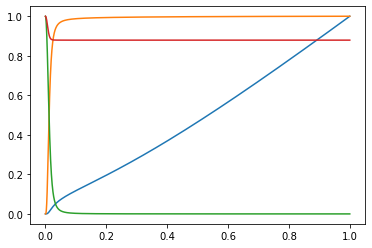

In [38]:
radius = np.array(A.r_vals)
mass = np.array(A.M_vals)
density = np.array(A.rho_vals)
luminosity = np.array(A.L_vals)
temperature = np.array(A.T_vals)


def search(lis, element):
    start = time.time()
    min_val = 1e50
    min_ind = 0
    for i in range(len(lis)):
        diff = abs(lis[i] - element)
        #print('chekin search', diff, i)
        if diff<min_val:
            min_val = diff
            min_ind = i
                
    print( "Took:", (time.time()-start)//60, " minutes and", (time.time()-start)%60 ,"seconds to search Rstar index")
    return min_ind

tau_Rstar = A.tau_vals[-1] - (2/3)
print(tau_Rstar)
index = search(A.tau_vals, tau_Rstar)

'''
r_star = a.r_vals[index]
m_star = a.M_vals[index]
l_star = a.L_vals[index]
'''

r_star = A.r_vals[A.surfaceRad()]
m_star = A.M_vals[A.surfaceRad()]
l_star = A.L_vals[A.surfaceRad()]

plt.plot(radius/r_star, mass/m_star)
plt.plot(radius/r_star, luminosity/l_star)
plt.plot(radius/r_star, density/58.56e3)
plt.plot(radius/r_star, temperature/8.23e6)

print(r_star)

In [6]:
def f(star, rho_c, T_c, step_size):
    
    print('density is -', rho_c)
    
    star_func = star(1e-3, rho_c, T_c, step_size)
    rho, T, M, L, tau, r = star_func.solve_DE()
    tau_Rstar = tau[-1] - (2/3)
    
    R_star_index = search(tau, tau_Rstar)
    print(R_star_index)
    
    L_star = L[R_star_index]
    T_star = T[R_star_index]
    R_star = r[R_star_index]
    L_true = (4.0*np.pi*sigma_sb*(R_star**2.0)*(T_star**4.0))
    
    print('root is - ', (L_star - L_true)/np.sqrt(L_star*L_true))
    
    return (L_star - L_true)/np.sqrt(L_star*L_true)


def bisection(f,rho_min,rho_max,T_c, step_size, N):
    '''
    Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(star, rho_min, T_c, step_size)*f(star, rho_max, T_c, step_size) >= 0:
        print("Bisection method fails.")
        return None
    a_n = rho_min
    b_n = rho_max
    m_n = 1e7
    while m_n > N:
    #for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        print('m_n', m_n)
        f_m_n = f(star, m_n, T_c, step_size)
        if f(star, a_n, T_c, step_size)*f_m_n < 0:
            print('first condition met')
            a_n = a_n
            b_n = m_n
        elif f(star, b_n, T_c, step_size)*f_m_n < 0:
            print('second condition met')
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2

In [7]:
def search(lis, element):
    start = time.time()
    min_val = 1e50
    min_ind = 0
    for i in range(len(lis)):
        diff = abs(lis[i] - element)
        #print('chekin search', diff, i)
        if diff<min_val:
            min_val = diff
            min_ind = i
                
    print( "Took:", (time.time()-start)//60, " minutes and", (time.time()-start)%60 ,"seconds to search Rstar index")
    return min_ind

In [8]:
star_func = star(1e-1, 58.56e3, 8.23e6, 1e2)
#star_func = star(1e-1, 10e3, 1000, 1e2)
rho, T, M, L, tau, r = star_func.solve_DE()

tau_Rstar = tau[-1] - (2/3)

print(tau_Rstar)

index = search(tau, tau_Rstar)
print(len(tau))
print(r[search(tau, tau_Rstar)])

Radius sets the condition
Took: 0.0  minutes and 1.8919239044189453 seconds to solve DE
737043697492.8702
Took: 0.0  minutes and 0.0050013065338134766 seconds to search Rstar index
9547
Took: 0.0  minutes and 0.0030150413513183594 seconds to search Rstar index
13922457332.065538


In [9]:
r[index]/Rsun

20.0121565790794

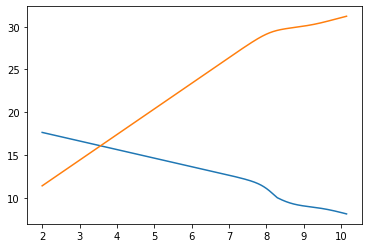

In [10]:
plt.plot(np.log10(r), np.log10(star_func.deltau_values))
plt.plot(np.log10(r), np.log10(M))

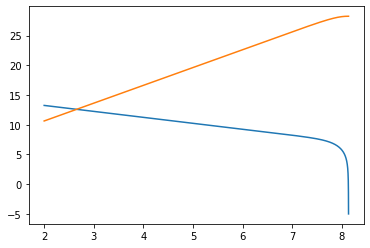

In [91]:
plt.plot(np.log10(r), np.log10(star_func.deltau_values))
plt.plot(np.log10(r), np.log10(M))

In [88]:
min(star_func.deltau_values)

965960.287232488

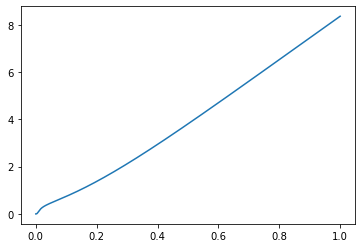

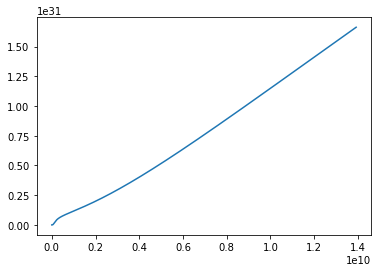

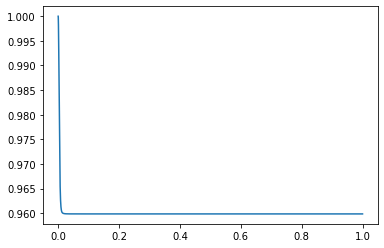

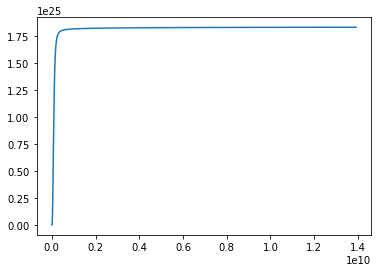

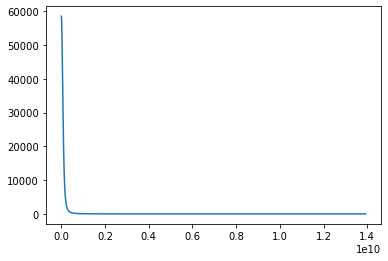

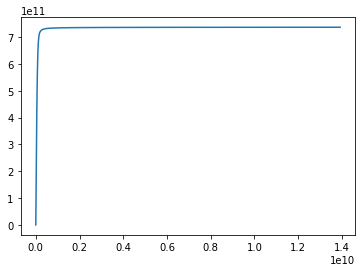

In [11]:
plt.plot(np.array(r)/r[index], np.array(M)/Msun)
plt.show()

plt.plot(r, M)
plt.show()

plt.plot(np.array(r)/r[index], np.array(T)/ 8.23e6)
plt.show()

plt.plot(r, L)
plt.show()

plt.plot(r, rho)
plt.show()

plt.plot(r, tau)
plt.show()

In [10]:
bisection(f, 0.3e3, 500e3, 1e5, 1e3, 0.001)

density is - 300.0
Took: 0.0  minutes and 3.769270420074463 seconds to solve DE
Took: 0.0  minutes and 0.0021278858184814453 seconds to search Rstar index
0
root is -  -57260755665.0385
density is - 500000.0
Took: 0.0  minutes and 4.90149712562561 seconds to solve DE
Took: 0.0  minutes and 0.004049062728881836 seconds to search Rstar index
0
root is -  -34356453.439230375
Bisection method fails.


In [49]:
r[index]/6.957e8

2430.887630886695

In [ ]:
'''
The program looks for tau_Rstar or a value close to it. Since the stepsizes are equal,
the program will favour one of the values and then take it to be Rstar. 
Thus, this algorithm is accurate to a stepsize.
For the right stepsize, it can result in a negligible difference.
'''

def search(lis, element):
    start = time.process_time()
    for i in range(len(lis)):
        if lis[i] == element or (lis[i] < element +(5e-2) and lis[i]> element -(5e-2)): # Bounds of acceptable discrepancy will depend on the inital conditions
            #print(i) # optional. It can be helpful in understanding how the search function works
            print('Time taken to search for R_star is', time.process_time() - start, 'seconds')
            return i

In [ ]:
plt.plot(r, tau, '.')
#plt.plot(rho, r, '.')